In [ ]:
#| hide
!pip install -Uqq nixtla utilsforecast

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# Forecasting web traffic

Our task is to forecast the next 7 days of daily visits to the website [cienciadedatos.net](cienciadedatos.net).

In this tutorial we will show:

* How to load time series data to be used for forecasting with TimeGPT

* How to create cross-validated forecasts with TimeGPT

This tutorial is an adaptation from [Joaquín Amat Rodrigo, Javier Escobar Ortiz, "Forecasting web traffic with machine learning and Python"](https://cienciadedatos.net/documentos/py37-forecasting-web-traffic-machine-learning.html). We will show you:

* how you can achieve almost 10% better forecasting results;

* using significantly less lines of code;

* in a fraction of the time needed to run the original tutorial.

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()    
    colab_badge('docs/use-cases/1_forecasting_web_traffic')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/use-cases/1_forecasting_web_traffic.ipynb)

## 1. Import packages
First, we import the required packages and initialize the Nixtla client.

In [ ]:
import pandas as pd
from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

> 👍 Use an Azure AI endpoint
> 
> To use an Azure AI endpoint, remember to set also the `base_url` argument:
> 
> `nixtla_client = NixtlaClient(base_url="you azure ai endpoint", api_key="your api_key")`

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

## 2. Load data

We load the website visit data, and set it to the right format to use with TimeGPT. In this case, we only need to add an identifier column for the timeseries, which we will call `daily_visits`.

In [ ]:
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/' +
       'master/data/visitas_por_dia_web_cienciadedatos.csv')
df = pd.read_csv(url, sep=',', parse_dates=[0], date_format='%d/%m/%y')
df['unique_id'] = 'daily_visits'

df.head(10)

,date,users,unique_id
0,2020-07-01,2324,daily_visits
1,2020-07-02,2201,daily_visits
2,2020-07-03,2146,daily_visits
3,2020-07-04,1666,daily_visits
4,2020-07-05,1433,daily_visits
5,2020-07-06,2195,daily_visits
6,2020-07-07,2240,daily_visits
7,2020-07-08,2295,daily_visits
8,2020-07-09,2279,daily_visits
9,2020-07-10,2155,daily_visits


That's it! No more preprocessing is necessary.

## 3. Cross-validation with TimeGPT

We can perform cross-validation on our data as follows:

In [ ]:
timegpt_cv_df = nixtla_client.cross_validation(
    df, 
    h=7, 
    n_windows=8, 
    time_col='date', 
    target_col='users', 
    freq='D',
    level=[80, 90, 99.5]
)
timegpt_cv_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,unique_id,date,cutoff,users,TimeGPT,TimeGPT-lo-99.5,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-hi-99.5
0,daily_visits,2021-07-01,2021-06-30,3123,3310.908447,3041.925497,3048.363220,3082.721924,3539.094971,3573.453674,3579.891397
1,daily_visits,2021-07-02,2021-06-30,2870,3090.971680,2793.535905,2838.480298,2853.750488,3328.192871,3343.463062,3388.407455
2,daily_visits,2021-07-03,2021-06-30,2020,2346.991455,2043.731296,2150.005078,2171.187012,2522.795898,2543.977832,2650.251614
3,daily_visits,2021-07-04,2021-06-30,1828,2182.191895,1836.848173,1897.684900,1929.914575,2434.469214,2466.698889,2527.535616
4,daily_visits,2021-07-05,2021-06-30,2722,3082.715088,2736.008055,2746.997034,2791.375342,3374.054834,3418.433142,3429.422121


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.cross_validation(..., model="azureai")`
> 
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`. 
> 
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

Here, we have performed a rolling cross-validation of 8 folds. Let's plot the cross-validated forecasts including the prediction intervals:

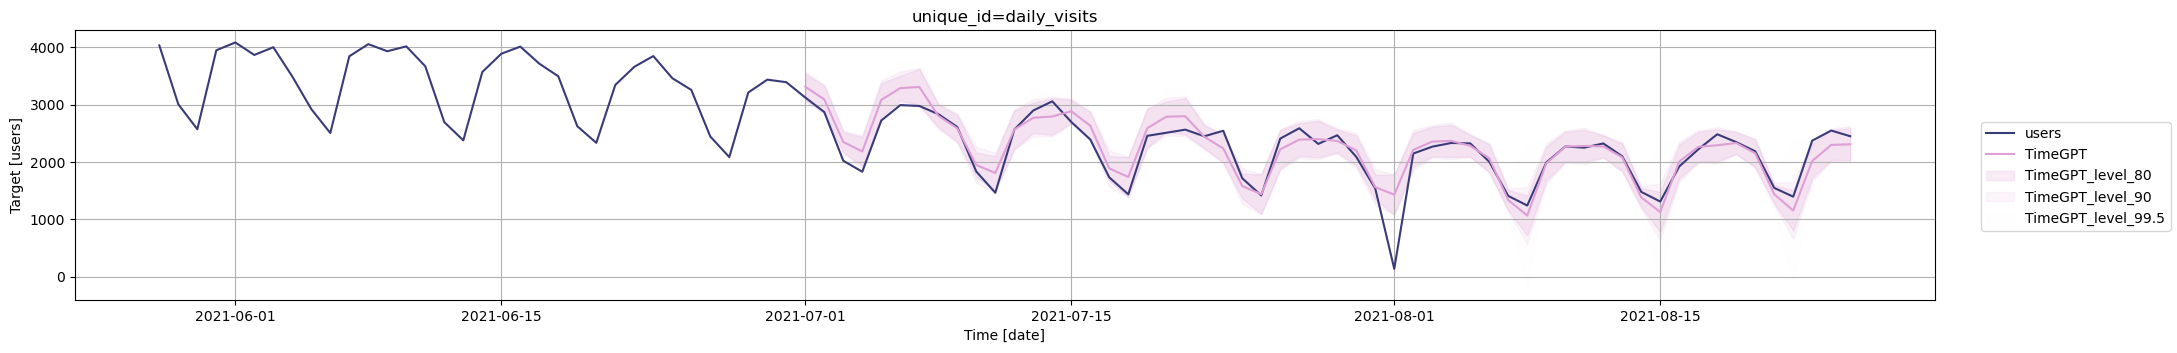

In [ ]:
nixtla_client.plot(
    df, 
    timegpt_cv_df.drop(columns=['cutoff', 'users']), 
    time_col='date',
    target_col='users',
    max_insample_length=90, 
    level=[80, 90, 99.5]
)

This looks reasonable, and very comparable to the results obtained [here](https://cienciadedatos.net/documentos/py37-forecasting-web-traffic-machine-learning.html).

Let's check the Mean Absolute Error of our cross-validation:

In [ ]:
from utilsforecast.losses import mae

In [ ]:
mae_timegpt = mae(df = timegpt_cv_df.drop(columns=['cutoff']),
    models=['TimeGPT'],
    target_col='users')

mae_timegpt

,unique_id,TimeGPT
0,daily_visits,167.691711


The MAE of our backtest is `167.69`. Hence, not only did TimeGPT achieve a lower MAE compared to the fully customized pipeline [here](https://cienciadedatos.net/documentos/py37-forecasting-web-traffic-machine-learning.html), the error of the forecast is also lower.

#### Exogenous variables

Now let's add some exogenous variables to see if we can improve the forecasting performance further.

We will add weekday indicators, which we will extract from the `date` column.

In [ ]:
# We have 7 days, for each day a separate column denoting 1/0
for i in range(7):
    df[f'week_day_{i + 1}'] = 1 * (df['date'].dt.weekday == i)

df.head(10)

,date,users,unique_id,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6,week_day_7
0,2020-07-01,2324,daily_visits,0,0,1,0,0,0,0
1,2020-07-02,2201,daily_visits,0,0,0,1,0,0,0
2,2020-07-03,2146,daily_visits,0,0,0,0,1,0,0
3,2020-07-04,1666,daily_visits,0,0,0,0,0,1,0
4,2020-07-05,1433,daily_visits,0,0,0,0,0,0,1
5,2020-07-06,2195,daily_visits,1,0,0,0,0,0,0
6,2020-07-07,2240,daily_visits,0,1,0,0,0,0,0
7,2020-07-08,2295,daily_visits,0,0,1,0,0,0,0
8,2020-07-09,2279,daily_visits,0,0,0,1,0,0,0
9,2020-07-10,2155,daily_visits,0,0,0,0,1,0,0


Let's rerun the cross-validation procedure with the added exogenous variables.

In [ ]:
timegpt_cv_df_with_ex = nixtla_client.cross_validation(
    df, 
    h=7, 
    n_windows=8, 
    time_col='date', 
    target_col='users', 
    freq='D',
    level=[80, 90, 99.5]
)
timegpt_cv_df_with_ex.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using the following exogenous variables: week_day_1, week_day_2, week_day_3, week_day_4, week_day_5, week_day_6, week_day_7
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using the following exogenous variables: week_day_1, week_day_2, week_day_3, week_day_4, week_day_5, week_day_6, week_day_7
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using the following exogenous variables: week_day_1, week_day_2, week_day_3, week_day_4, week_day_5, week_day_6, week_da

,unique_id,date,cutoff,users,TimeGPT,TimeGPT-lo-99.5,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-hi-99.5
0,daily_visits,2021-07-01,2021-06-30,3123,3314.773743,2793.566942,3043.304261,3085.668122,3543.879364,3586.243226,3835.980544
1,daily_visits,2021-07-02,2021-06-30,2870,3093.066529,2139.727892,2725.964112,2779.082154,3407.050904,3460.168946,4046.405166
2,daily_visits,2021-07-03,2021-06-30,2020,2347.973573,1386.090529,1915.487550,1973.679628,2722.267519,2780.459596,3309.856618
3,daily_visits,2021-07-04,2021-06-30,1828,2182.467408,1003.677454,1681.246491,1874.572327,2490.362488,2683.688324,3361.257361
4,daily_visits,2021-07-05,2021-06-30,2722,3083.629453,1257.248435,2220.430357,2556.408628,3610.850279,3946.828550,4910.010472


Let's plot our forecasts again and calculate our error.

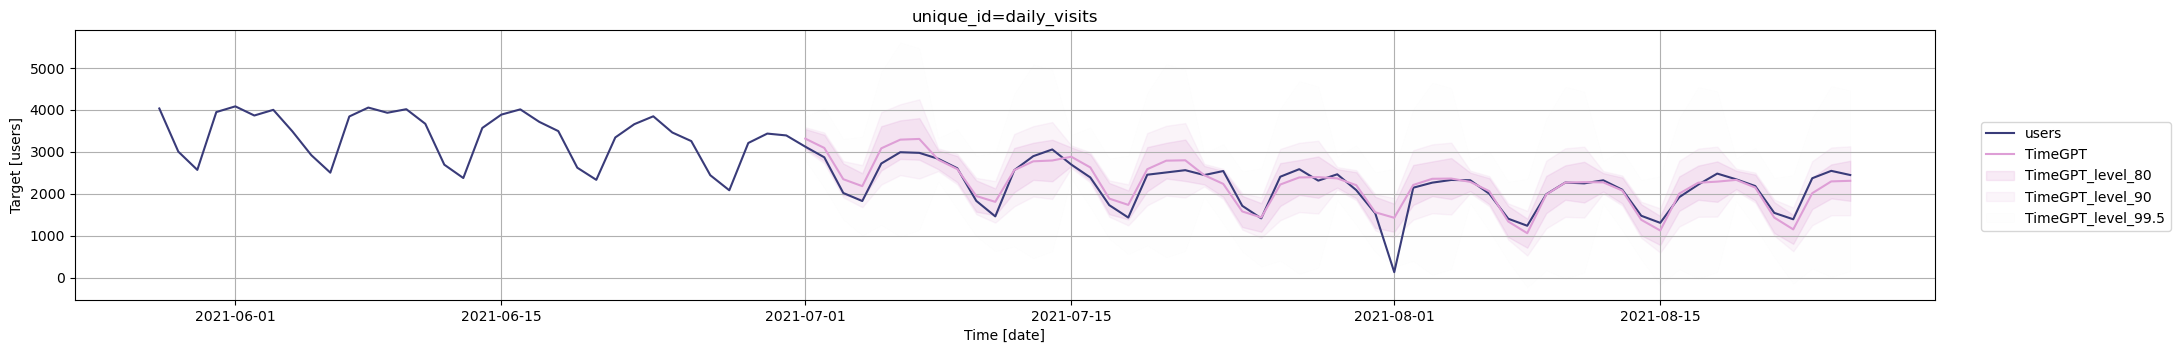

In [ ]:
nixtla_client.plot(
    df, 
    timegpt_cv_df_with_ex.drop(columns=['cutoff', 'users']), 
    time_col='date',
    target_col='users',
    max_insample_length=90, 
    level=[80, 90, 99.5]
)

In [ ]:
mae_timegpt_with_exogenous = mae(df = timegpt_cv_df_with_ex.drop(columns=['cutoff']),
    models=['TimeGPT'],
    target_col='users')

mae_timegpt_with_exogenous

,unique_id,TimeGPT
0,daily_visits,167.22857


To conclude, we obtain the following forecast results in this notebook:

In [ ]:
mae_timegpt['Exogenous features'] = False
mae_timegpt_with_exogenous['Exogenous features'] = True

df_results = pd.concat([mae_timegpt, mae_timegpt_with_exogenous])
df_results = df_results.rename(columns={'TimeGPT':'MAE backtest'})
df_results = df_results.drop(columns={'unique_id'})
df_results['model'] = 'TimeGPT'

df_results[['model', 'Exogenous features', 'MAE backtest']]

,model,Exogenous features,MAE backtest
0,TimeGPT,False,167.691711
0,TimeGPT,True,167.228570


We've shown how to forecast daily visits of a website. We achieved almost 10% better forecasting results as compared to the [original tutorial](https://cienciadedatos.net/documentos/py37-forecasting-web-traffic-machine-learning.html), using significantly less lines of code, in a fraction of the time required to run everything.

Did you notice how little effort that took? What you did not have to do, is:

- Elaborate data preprocessing - just a table with timeseries is sufficient
- Creating a validation- and test set - TimeGPT handles the cross-validation in a single function
- Choosing and testing different models - It's just a single call to TimeGPT
- Hyperparameter tuning - Not necessary.

Happy forecasting!